In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# import required modules
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from fractions import Fraction
import IPython.display as ipd
pi = np.pi

# Functions for musical interval analysis



In [14]:
# define note names and pitches
def pitch_dict_create():
    
    # init note names and interval names
    note = ["C","Db","D","Eb","E","F","Gb","G","Ab","A","Bb","B"]
    tet = len(note)
    intervals = ['unison','min 2nd','maj 2nd','min 3rd','maj 3rd','prf 4th',
             'tritone','prf 5th','min 6th','maj 6th','dom 7th','maj 7th','octave']
    # init vars
    octave = 0
    count = 0
    note_names = []
    pitch = {}

    # 9 octaves of note names in scientific format
    # ex. A4 is A in the 4th octave, middle A
    for number in range(108):
        note_names.append("%s%d" %(note[number % 12], octave))
        count = count+1
        if count == 12:
            octave = octave+1
            count = 0

    # 9 octaves of pitches matched with note names
    A4 = 440     # A440 pitch standard 440 Hz
    for k in range(108):
        pitch[note_names[k]] = A4 * (2**(1/12))**(k-57)

    # above pitch equation:
    # all notes relative to standard A440 pitch
    # frequency of a pitch relative to standard is:
    # ratio = (2^(1/12))^n
    # where n is the # of half-steps from the standard to the pitch
    # n = k-57 such that n=0 corresponds to A440 with 108 pitches
    
    notes = {'intervals':intervals,'names':note_names,'pitch':pitch}
    return notes

In [15]:
# setup plotting dimensions
# setup for dsp (not used yet)
# upsample to Np, power of 2 for N-point (Np) FFT
# input: T seconds long, fs is sample rate (Hz)
def dim_def(T,fs):
    N = round(T * fs)     # number of samples
    
    # with zero padding, make Np at least 2*N
    k = 5          # N to the kth power
    Np = 2**k      # desired length of zero padded input signal for an N-point FFT
    while N*2 > Np:
        k = k + 1
        Np = 2**k

    Ts = 1/fs        # delta t
    Ws = 2*np.pi*fs  # sampling freq (rad)

    # zero pad
    C = int((Np-N)/2)       # index at t = 0
    D = C + N               # index at t = T
    n = np.linspace(0,N,N)
    n_pad = np.linspace(0,Np,Np)
    
    dimensions = {'numsamps':N,'N-point':Np,'Ts':Ts,'nstart_index':C,
                 'nend_index':D,'n_index':n,'n_pad_index':n_pad}

    return dimensions

In [36]:
# function for summing two notes by interval
# N in samples, fs in Hz, fund is string ('A4'),
# interval is an integer (num semitones)
# pitch is given by pitch_dict_create()
def two_pure_tones(N,fs,fund,pitch,interval):
    
    # find fund, select note by given interval:
    f0 = pitch[fund]
    temp = list(pitch)
    try: 
        res = temp[temp.index(fund) + interval] 
    except (ValueError, IndexError): 
        res = None
    fb = pitch[str(res)]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    wb = 2*pi*fb
    
    sin_0 = np.sin(w0*Ts*n)
    sin_b = np.sin(wb*Ts*n)
    x = sin_0 + sin_b
    x_title = '%d half-step interval, %s from %.1f Hz' % (interval,notes['intervals'][interval],f0)
    
    # output is x[] time series, x title string
    return x,x_title

# function for summing odd or even harmonics
# harm is a string ('even','odd','overlay')
# num_harm is an integer
def simple_harmonic(N,fs,fund,pitch,harm,num_harm):
    f0 = pitch[fund]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    
    if harm == 'even':
        sig = np.zeros(N)
        for m in range(num_harm):
            even = 2*(m+1)
            harm = (2/even)*np.sin(w0*even*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d even harmonics' % num_harm
    elif harm == 'odd':
        sig = np.zeros(N)
        for m in range(num_harm):
            odd = 2+(2*m-1)
            harm = (1/odd)*np.sin(w0*odd*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d odd harmonics' % num_harm
    elif harm == 'overlay':
        fig= plt.figure(figsize=(15,6))
        t = np.linspace(0,Ts*N,N)
        for m in range(num_harm):
            x = np.zeros(N)
            harm = (1/(1+m))*np.sin(w0*(1+m)*Ts*n)
            x = x + harm
            x_title = 'all harmonics to %d' % num_harm
            plt.plot(t,harm)
            plt.title('%d harmonics' % num_harm)
            plt.xlabel('time (s)')
        
    return x,x_title

In [ ]:
# function to get note names of harmonics created by simple_harmonic()


In [17]:
# plot waveform
def plot_waveforms(Ts,N,x,x_title):
    t = np.linspace(0,Ts*N,N)
    fig= plt.figure(figsize=(14,5))

    plt.plot(t,x)
    plt.title(x_title)
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')
    
# plot waveform by frequency
def plot_freq(Ts,N,f1,f2):
    n = np.linspace(0,N,N)
    t = np.linspace(0,Ts*N,N)
    w1 = 2*pi*f1
    w2 = 2*pi*f2
    sin_1 = np.sin(w1*Ts*n)
    sin_2 = np.sin(w2*Ts*n)
    x = sin_1 + sin_2
    
    fig= plt.figure(figsize=(14,5))
    plt.plot(t,x)
    plt.title('%.1f Hz and %.1f Hz' % (f1,f2))
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')

In [18]:
# need functions to determine how close 
# the given interval is to a 'simple' one
# the closer to a simple ratio, the more
# consonant the interval

# get ratio info from notes
# b is the higher note, in Hz
def f_to_ratio(b,a):
    b = int(round(b))
    a = int(round(a))
    div = np.gcd(b,a)
    nume = int(b/div)
    deno = int(a/div)
    rat = nume/deno
    return nume,deno,div,rat

# get closest simple ratio
# from num/denom given by f_to_ratio()
def close_to_simple_ratio(nume,deno):
    pmin_diff = 1000
    for i in range(12):
        for j in range(11):
            diff = np.abs(nume/deno - i/(j+1))
            if diff < pmin_diff:
                pmin_diff = diff
                closest_num = i
                closest_den = (j+1)
            else:
                diff = diff
    return closest_num,closest_den,pmin_diff

# show closest simple ratios for an octave of intervals
# starting at A440
def ratio_list_create(note_names,pitch):
    offset = 57            # index of A440 from notes[]
    fund = note_names[offset]   # notes[57] = 'A4'
    f0 = pitch[fund]
    interval_ratio = {}
    print('fundamental: %s' % fund)
    print('')
    for k in range(13):
        fb = pitch[note_names[offset+k]]
        nume,deno,div,rat = f_to_ratio(fb,f0)
        c_num,c_den,diff = close_to_simple_ratio(nume,deno)
        interval_ratio[intervals[k]] = Fraction(c_num,c_den)
        # print results
        print('interval: %s, %s' % (intervals[k],note_names[offset+k]))
        print('given note ratio: %d / %d = %.5f with gcd %d' %(nume,deno,rat,div))
        print('closest simple ratio: %d / %d' %(c_num,c_den))
        print('diff btwn just and equal: %.5f' % diff)
        print('')
        
    return interval_ratio

In [19]:
# function that takes a note and interval, returns the note at interval
def note_interval(fund,interval,note_names):
    fund_index = note_names.index(fund)
    note_index = fund_index + interval
    note = note_names[note_index]
    
    return note

In [20]:
# make lists of various scale intervals
# taken from Jamey Abersold scale syllabus
# scales are listed by step sizes in semitones
scales = {
    'major':      [2,2,1,2,2,2,1],
    'dimW':       [2,1,2,1,2,1,2,1],
    'dimH':       [1,2,1,2,1,2,1,2],
    'pentmaj':    [2,2,3,2,3],
    'bebopmaj':   [2,2,1,2,1,1,2,1],
    'harmmaj':    [2,2,1,2,1,3,1],
    'lydaug':     [2,2,2,2,1,2,1],
    'augment':    [3,1,3,1,3,1],
    'blues':      [3,2,1,1,3,2]
}

# generate modes from major
modes = ['ionian','dorian','phrygian','lydian',
         'mixolydian','aeolian','locrian']
for k in range(6):
    scales[modes[k+1]] = np.roll(scales['major'],-(k+1))

# lists a given scale by name from scales dictionary
# for a given root note
def list_scale(root,name,scales,note_names):
    scale = []
    root_index = note_names.index(root)
    steps = scales[name]
    for k in range(len(steps)):
        index = root_index + sum(steps[:k])
        scale.append(note_names[index])
        
    return scale

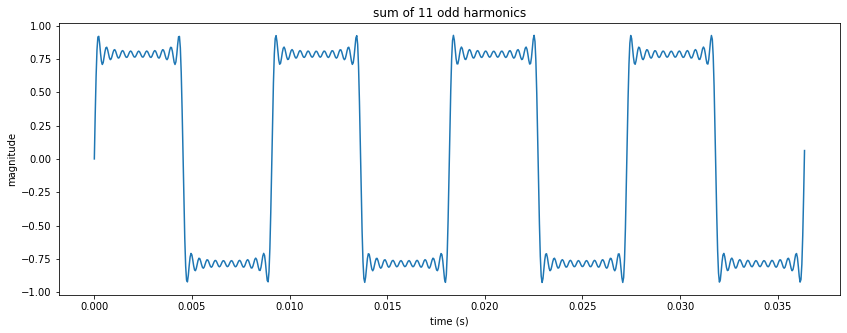

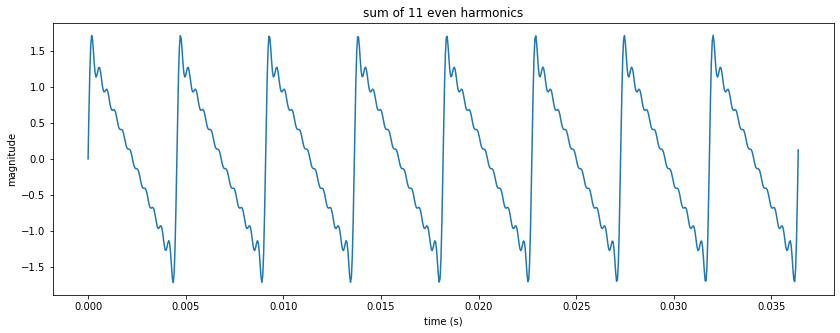

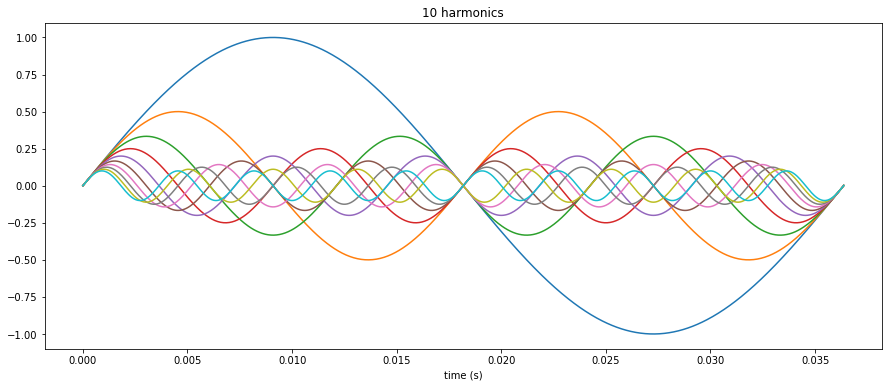

In [144]:
# setup note elements
notes = pitch_dict_create()
intervals = notes['intervals']
note_names = notes['names']
pitch = notes['pitch']

# setup dimensions
T = 1/27.5      # T seconds long
fs = 22050      # Hz
nyq = round(int(22050/2))  # highest freq before aliasing
dimensions = dim_def(T,fs)
Ts = dimensions['Ts']
n = dimensions['n_index']
N = dimensions['numsamps']
Np = dimensions['N-point']
C = dimensions['nstart_index']
D = dimensions['nend_index']
n_pad = dimensions['n_pad_index']

# create and plot waveform
x,x_title = simple_harmonic(N,fs,'A2',pitch,'odd',11)
plot_waveforms(Ts,N,x,x_title)

x,x_title = simple_harmonic(N,fs,'A2',pitch,'even',11)
plot_waveforms(Ts,N,x,x_title)

# plot an overlay of the harmonics
# A0 is at 27.5 Hz, N = 800, therefore:
# 1/(f_A0) ~= N/fs
x,x_title = simple_harmonic(N,fs,'A0',pitch,'overlay',10)

interval: unison, A4
given note ratio: 1 / 1 = 1.00000 with gcd 440
closest simple ratio: 1 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


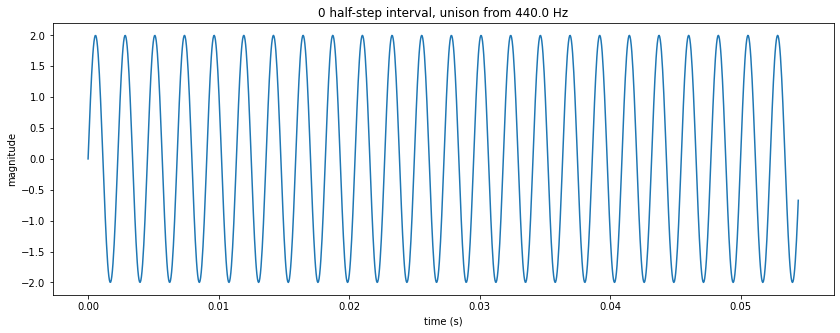

interval: min 2nd, Bb4
given note ratio: 233 / 220 = 1.05909 with gcd 2
closest simple ratio: 11 / 10
absolute diff in ratio btwn just and equal temperament: 0.04091


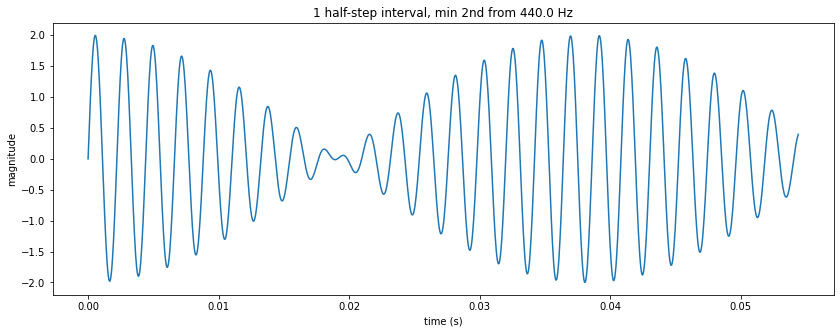

interval: maj 2nd, B4
given note ratio: 493 / 440 = 1.12045 with gcd 1
closest simple ratio: 9 / 8
absolute diff in ratio btwn just and equal temperament: 0.00455


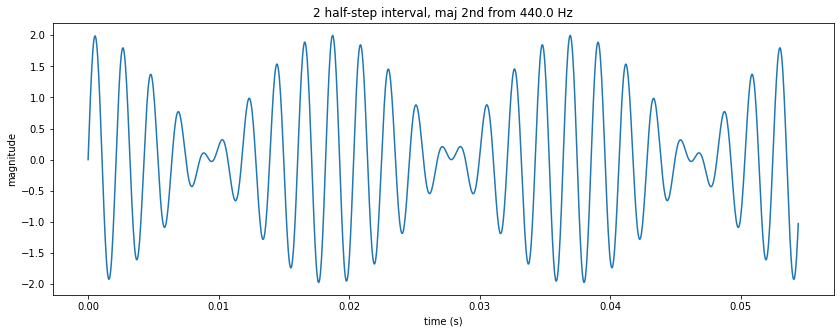

interval: min 3rd, C5
given note ratio: 523 / 440 = 1.18864 with gcd 1
closest simple ratio: 6 / 5
absolute diff in ratio btwn just and equal temperament: 0.01136


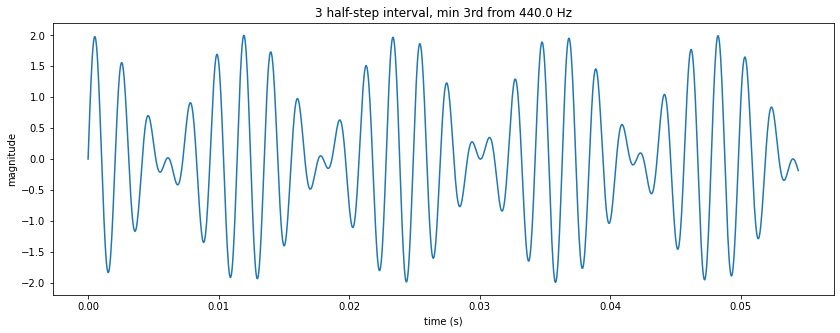

interval: maj 3rd, Db5
given note ratio: 277 / 220 = 1.25909 with gcd 2
closest simple ratio: 5 / 4
absolute diff in ratio btwn just and equal temperament: 0.00909


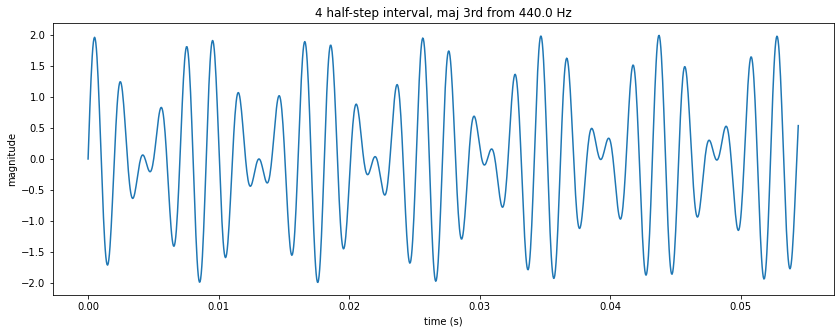

interval: prf 4th, D5
given note ratio: 587 / 440 = 1.33409 with gcd 1
closest simple ratio: 4 / 3
absolute diff in ratio btwn just and equal temperament: 0.00076


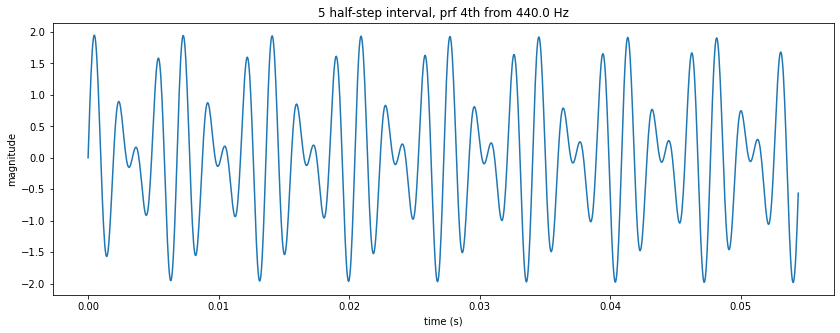

interval: tritone, Eb5
given note ratio: 311 / 220 = 1.41364 with gcd 2
closest simple ratio: 7 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


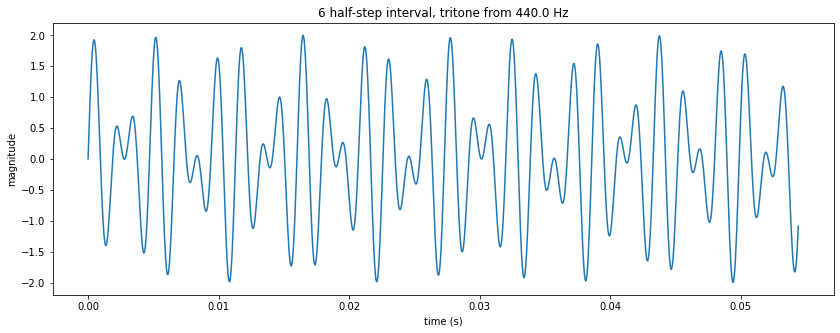

interval: prf 5th, E5
given note ratio: 659 / 440 = 1.49773 with gcd 1
closest simple ratio: 3 / 2
absolute diff in ratio btwn just and equal temperament: 0.00227


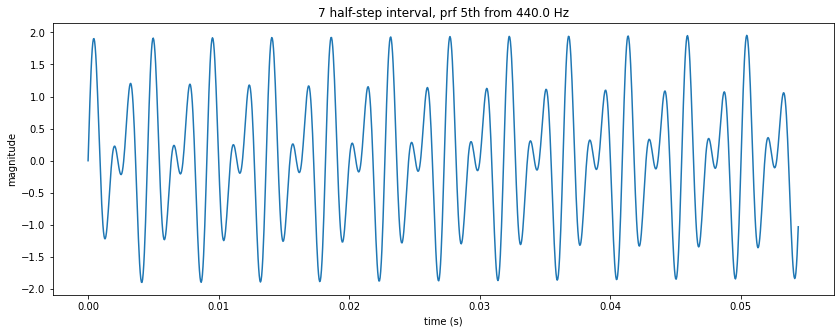

interval: min 6th, F5
given note ratio: 349 / 220 = 1.58636 with gcd 2
closest simple ratio: 8 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


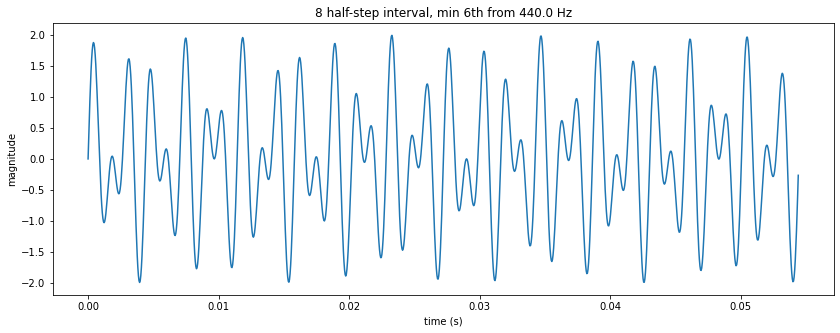

interval: maj 6th, Gb5
given note ratio: 739 / 440 = 1.67955 with gcd 1
closest simple ratio: 5 / 3
absolute diff in ratio btwn just and equal temperament: 0.01288


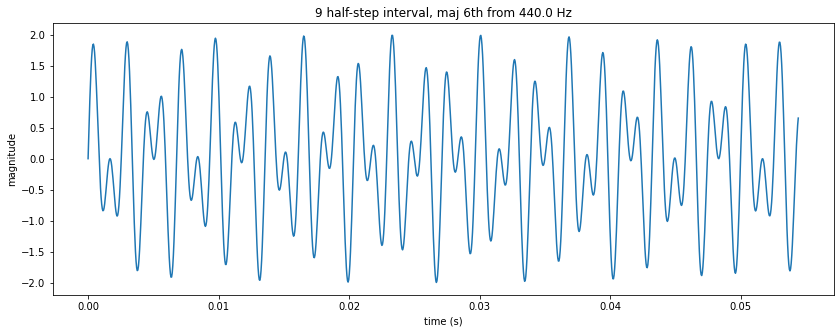

interval: dom 7th, G5
given note ratio: 783 / 440 = 1.77955 with gcd 1
closest simple ratio: 9 / 5
absolute diff in ratio btwn just and equal temperament: 0.02045


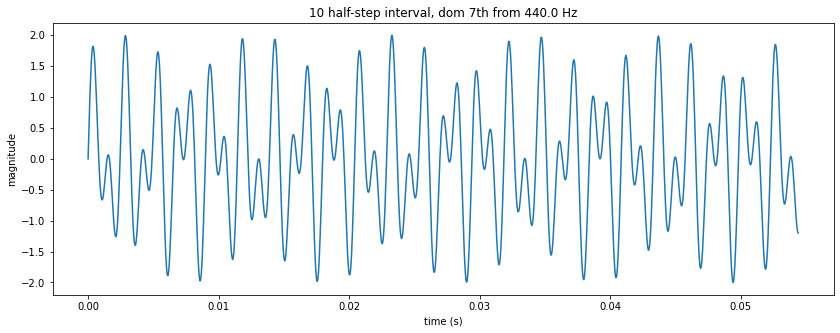

interval: maj 7th, Ab5
given note ratio: 83 / 44 = 1.88636 with gcd 10
closest simple ratio: 11 / 6
absolute diff in ratio btwn just and equal temperament: 0.05303


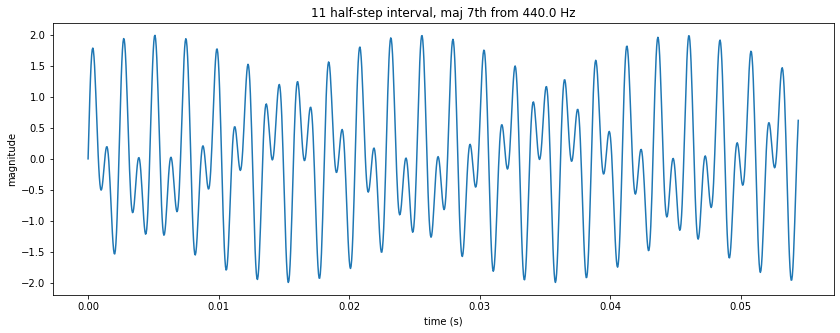

interval: octave, A5
given note ratio: 2 / 1 = 2.00000 with gcd 440
closest simple ratio: 2 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


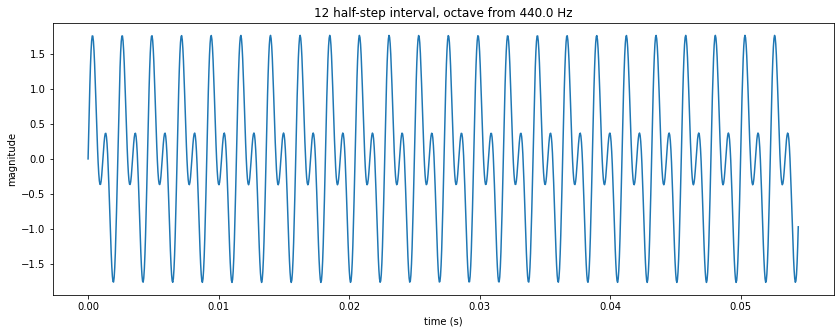

In [47]:
# interval analysis
# use a specific N value:
N = 1200

# show interval ratios
#interval_ratio = ratio_list_create(note_names,pitch)
# defunct, implemented into for loop below

# plot 12 intervals
offset = note_names.index('A4')
f0 = pitch['A4']
for j in range(13):
    
    fb = pitch[note_names[offset+j]]
    nume,deno,div,rat = f_to_ratio(fb,f0)
    c_num,c_den,diff = close_to_simple_ratio(nume,deno)
    perc_diff = 
    interval_ratio[intervals[j]] = Fraction(c_num,c_den)
    # print interval stats
    print('interval: %s, %s' % (intervals[j],note_names[offset+j]))
    print('given note ratio: %d / %d = %.5f with gcd %d' %(nume,deno,rat,div))
    print('closest simple ratio: %d / %d' %(c_num,c_den))
    print('absolute diff in ratio btwn just and equal temperament: %.5f' % diff)
    
    x,x_title = two_pure_tones(N,fs,'A4',pitch,j)
    plot_waveforms(Ts,N,x,x_title)
    plt.show()

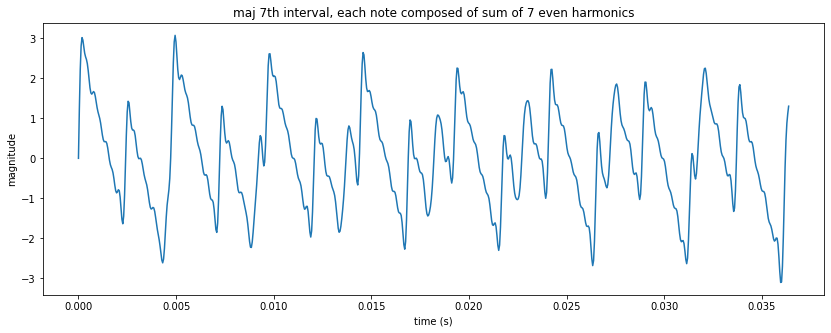

In [147]:
# plot two tones with harmonics summed
# choose notes
f0 = 'A2'
fb = 'Ab3'

# get interval name from distance between note names
semi_int = (note_names.index(fb) - note_names.index(f0)) % 12
interval_name = intervals[semi_int]

# combine waveforms and plot
num_harm = 7
harm_type = 'even'
x1,x1_title = simple_harmonic(N,fs,f0,pitch,harm_type,num_harm)
x2,_ = simple_harmonic(N,fs,fb,pitch,harm_type,num_harm)
x = x1 + x2
x_title = '%s interval, each note composed of ' %(interval_name) + x1_title
plot_waveforms(Ts,N,x,x_title)

In [186]:
# Python3 program for the above approach
# https://www.geeksforgeeks.org/find-indices-of-all-local-maxima-and-local-minima-in-an-array/
  
# Function to find all the local maxima  
# and minima in the given array arr[]  
  
def findLocalMaximaMinima(n, arr):  
  
    # Empty lists to store points of  
    # local maxima and minima  
    mx = []  
    mn = []  
  
    # Checking whether the first point is  
    # local maxima or minima or neither  
    if(arr[0] > arr[1]):  
        mx.append(0)  
    elif(arr[0] < arr[1]):  
        mn.append(0)  
  
    # Iterating over all points to check  
    # local maxima and local minima  
    for i in range(1, n-1):  
  
        # Condition for local minima  
        if(arr[i-1] > arr[i] < arr[i + 1]):  
            mn.append(i)  
  
        # Condition for local maxima  
        elif(arr[i-1] < arr[i] > arr[i + 1]):  
            mx.append(i)  
  
    # Checking whether the last point is  
    # local maxima or minima or neither  
    if(arr[-1] > arr[-2]):  
        mx.append(n-1)  
    elif(arr[-1] < arr[-2]):  
        mn.append(n-1)  
        
    return mx,mn

In [187]:
len(mx)

26

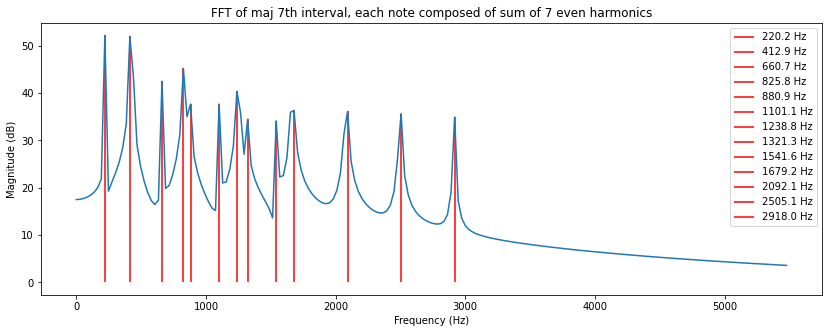

In [190]:
# plot spectral content
# plot fft of original waveform
plotlen = N//4
Y = scipy.fft.fft(x)
Y_mag = 20*np.log10(np.absolute(Y))
f = np.linspace(0, fs, N)
plt.figure(figsize=(14, 5))
plt.title('FFT of %s' % x_title)
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
mx,mn = findLocalMaximaMinima(N, Y_mag[:N])

for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],0,Y_mag[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))

plt.legend()

In [ ]:
for p in mx:
    plt.vlines(mx[p],20,50,colors='r',label='%.1f Hz' %(mx[p]))
plt.legend()

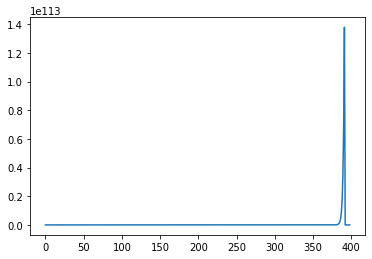

In [128]:
# find frequency density centers from fft
L = 7
weights = y
for k in range(len(y)):
    if k > L and k < len(y) - L:
        weights[k] = sum(y[k-L:k+L])

#weights = 20*np.log10(weights)
plt.plot(weights)

In [41]:
# scale stuff
root = 'A4'
scale_name = 'major'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

root = 'A4'
scale_name = 'aeolian'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

root = 'D3'
scale_name = 'phrygian'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

# note interval
fund = 'A4'
interval = 2
print('given: %s fundamental,' % fund)
print('give the note %d half steps up: ' % interval)
print(note_interval('A4',2,note_names))

list A4 major scale:
['A4', 'B4', 'Db5', 'D5', 'E5', 'Gb5', 'Ab5']

list A4 aeolian scale:
['A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5']

list D3 phrygian scale:
['D3', 'Eb3', 'F3', 'G3', 'A3', 'Bb3', 'C4']

given: A4 fundamental,
give the note 2 half steps up: 
B4


In [42]:
for j in range(13):
    x,x_title = two_pure_tones(N,fs,'A4',pitch,j)
    #plot_waveforms(Ts,T,x,x_title)

In [43]:
# test audio generation
T = 2
N = T*fs
x,x_title = two_pure_tones(N,fs,'A4',pitch,11)
ipd.Audio(x,rate=fs)